In [5]:
import pandas as pd

# Read the CSV file into a DataFrame
column_names = ["text", "is_hate"]

df = pd.read_csv('1.preprocessed_data.csv', on_bad_lines='skip', sep=",", encoding='iso-8859-1', header=0, names=column_names)
df['is_hate'] = df['is_hate'].astype(bool)
df['text'] = df['text'].astype('str')
df.head()

,text,is_hate
0,ponnayo danne kellek aduwa gaman laga inna kol...,True
1,ape harak samjeta eka honda adrshyak,False
2,tpita pisuda yako man htuwe atta kiyala aiyo,False
3,kimbak eduwoth ape untath amma thaththawath pe...,True
4,lisan nathawa yanna puluwan yako api dannawa o...,False


In [6]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Splitting the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 256

def tokenize_and_prepare_data(df):
    tokens = tokenizer(df['text'].tolist(), max_length=max_length, truncation=True, padding='max_length', return_tensors="pt")
    # Convert boolean tensor to long tensor
    return tokens.input_ids, tokens.attention_mask, torch.tensor(df['is_hate'].tolist()).long()

train_input_ids, train_attention_mask, train_labels = tokenize_and_prepare_data(train_df)
test_input_ids, test_attention_mask, test_labels = tokenize_and_prepare_data(test_df)

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 16
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_function = CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_function(logits.view(-1, 2), labels.view(-1))
        
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    total_eval_accuracy = 0
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        total_eval_accuracy += (predictions == labels).sum().item()
    
    avg_val_accuracy = total_eval_accuracy / len(test_df)
    print(f"Epoch: {epoch+1}, Validation Accuracy: {avg_val_accuracy:.2f}")

# Prediction function
def predict_hate(text):
    tokens = tokenizer(text, max_length=max_length, truncation=True, padding='max_length', return_tensors="pt")
    input_ids = tokens.input_ids.to(device)
    attention_mask = tokens.attention_mask.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return bool(prediction)

# Test prediction
text = "Your example text here"
print(predict_hate(text))


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Epoch: 1, Validation Accuracy: 0.59
Epoch: 2, Validation Accuracy: 0.61
Epoch: 3, Validation Accuracy: 0.71
False


#### took 30mins

In [7]:
from sklearn.metrics import classification_report
# Evaluation and Prediction
model.eval()
all_predictions = []
all_true_labels = []
all_probs = []

for batch in test_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(logits, dim=-1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_true_labels.extend(labels.cpu().numpy())
    all_probs.extend(probabilities[:, 1].cpu().numpy())  # keep probabilities for the positive class only

# Classification Report
report = classification_report(all_true_labels, all_predictions, target_names=['True', 'False'])
print(report)


              precision    recall  f1-score   support

        True       0.71      0.87      0.78       260
       False       0.72      0.49      0.58       181

    accuracy                           0.71       441
   macro avg       0.71      0.68      0.68       441
weighted avg       0.71      0.71      0.70       441



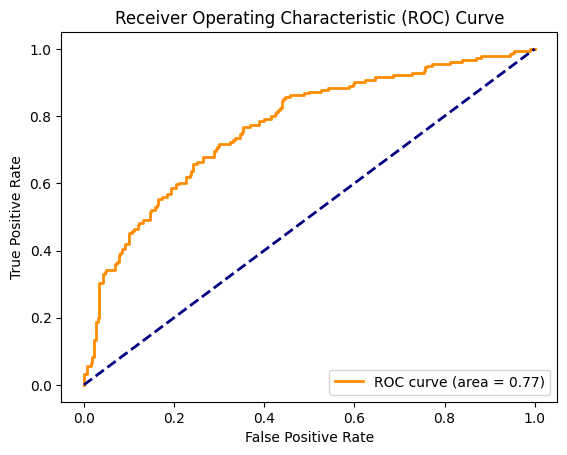

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(all_true_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

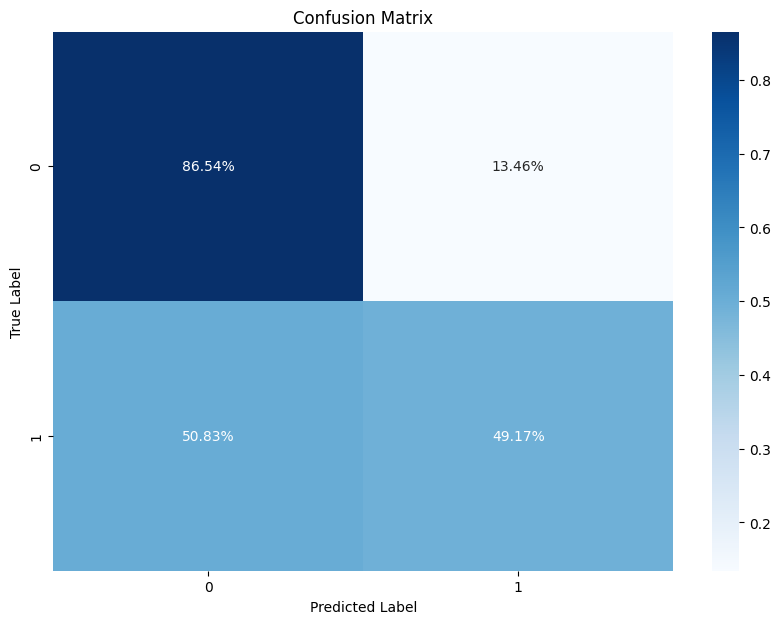

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Assuming all_true_labels and all_predictions are your data
cm = confusion_matrix(all_true_labels, all_predictions)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [10]:
import pickle

# save the values to a file
with open('2.13 RoBERTa.pkl', 'wb') as f:
    pickle.dump({
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'cm_percentage': cm, 'report': report
    }, f)


### Saving the Trained Model

In [11]:
# Save the model
model_save_path = '2.13 RoBERTa'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


('2.13 RoBERTa/tokenizer_config.json',
 '2.13 RoBERTa/special_tokens_map.json',
 '2.13 RoBERTa/vocab.json',
 '2.13 RoBERTa/merges.txt',
 '2.13 RoBERTa/added_tokens.json')

In [12]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the model
model_save_path = '2.13 RoBERTa'
tokenizer = RobertaTokenizer.from_pretrained(model_save_path)
model = RobertaForSequenceClassification.from_pretrained(model_save_path)


In [13]:
# Making predictions with the loaded model
def predict_hate(text):
    tokens = tokenizer(text, max_length=256, truncation=True, padding='max_length', return_tensors="pt")
    input_ids = tokens.input_ids.to(device)
    attention_mask = tokens.attention_mask.to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    return bool(prediction)

# Test prediction
text = "kalakanni"
print(predict_hate(text))


True
